Loaded T2_2000-03.nc
Loaded SNOWNC_2000-03.nc
Loaded RAINNC_2000-03.nc
Loaded HAILNC_2000-03.nc
Loaded GRAUPELNC_2000-03.nc
Loaded I_RAINNC_2000-03.nc


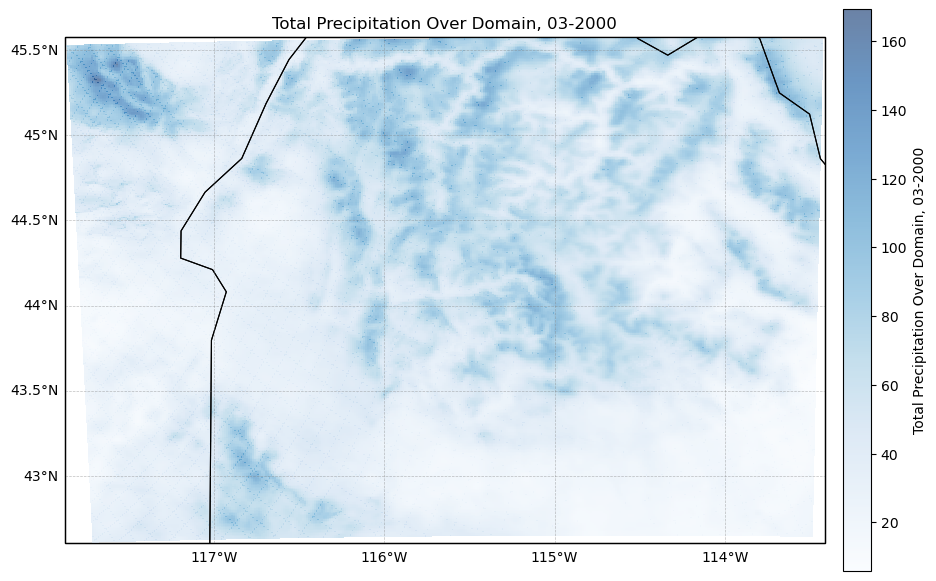

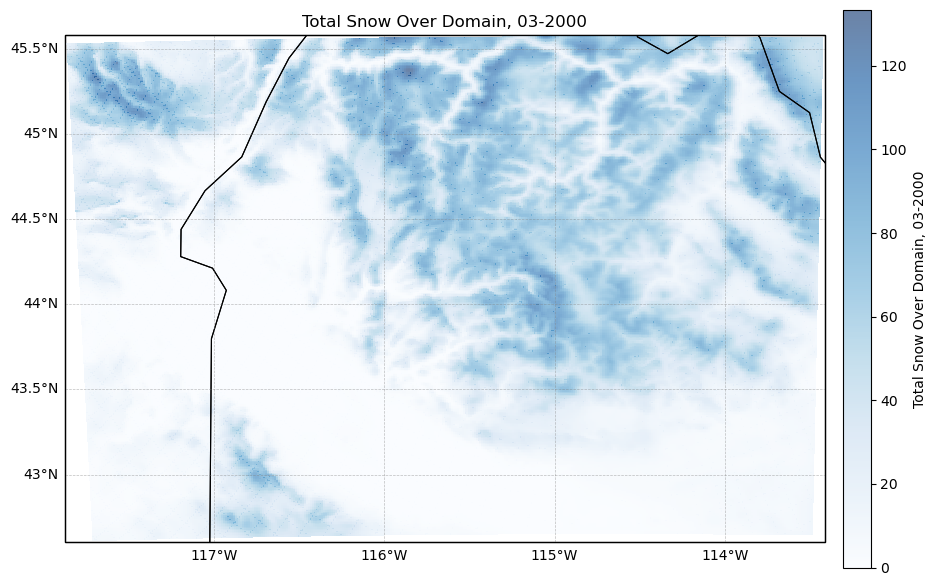

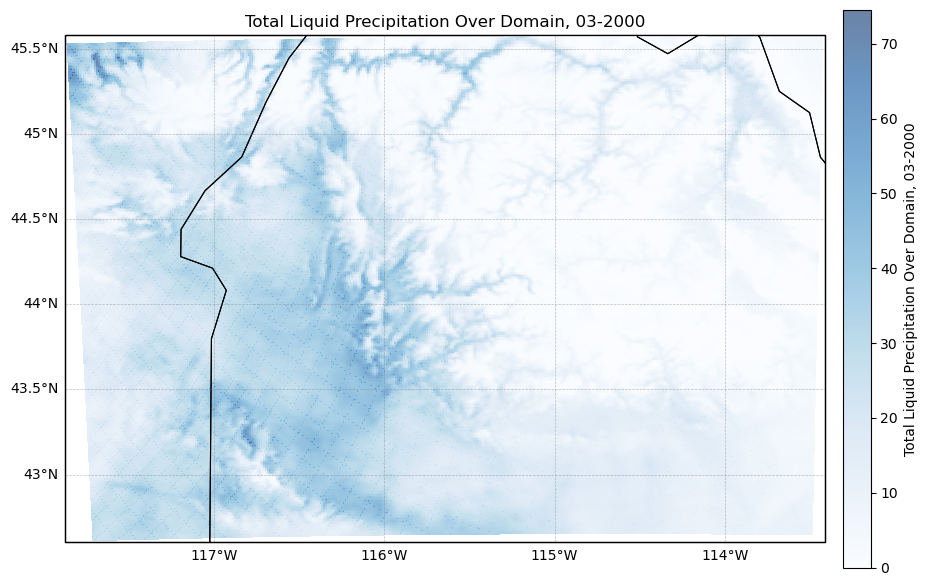

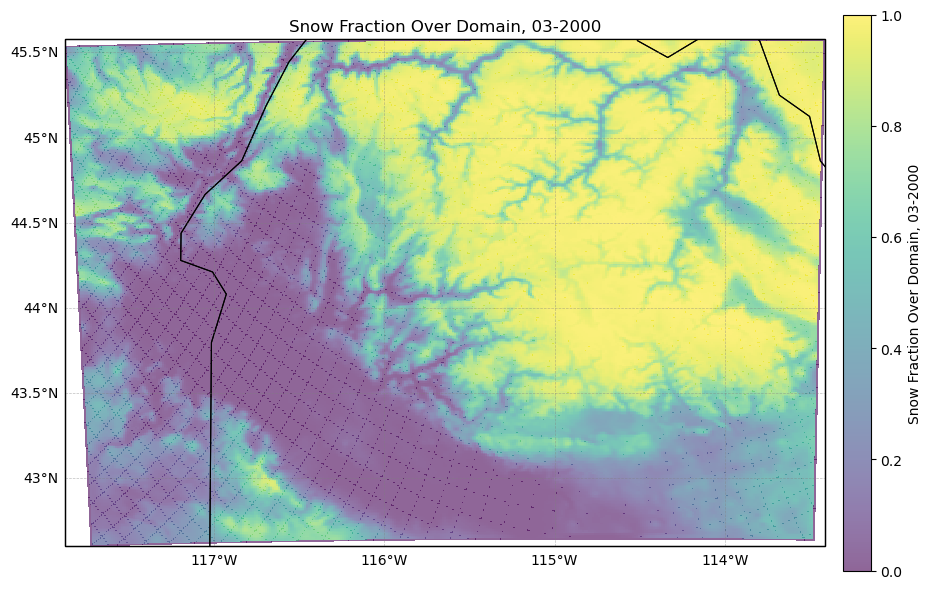

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import plot_utils
reload(plot_utils)
from plot_utils import plot_cartopy, load_wrf_var, fix_accum_reset # import after reloading file

# === DATA DIRECTORIES ===
d01_dir = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d01/"
d02_dir = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d02/"

# === CONFIGURATION ===
current_plot_file = d02_dir # update based on which dataset to plot
month = "03"
year = "2000"
target_location = "Domain"
epsilon = 1e-6 # avoid division by zero
min_precip = 1.0 # threshold for masking (mm)

# === LOAD DATA ===
t2     = load_wrf_var("T2",     current_plot_file, year, month)
lats   = t2['XLAT'][0].values
lons   = t2['XLONG'][0].values
snownc = load_wrf_var("SNOWNC", current_plot_file, year, month)
rainnc = load_wrf_var("RAINNC", current_plot_file, year, month)
hailnc = load_wrf_var("HAILNC", current_plot_file, year, month)
graup  = load_wrf_var("GRAUPELNC", current_plot_file, year, month)
count = load_wrf_var("I_RAINNC", current_plot_file, year, month)

# === CALCULATE TOTALS ===
precip_total = fix_accum_reset(rainnc['RAINNC']) # TODO: Adjust to use I_RAINNC and remove fix_accum_reset
snow_total   = snownc['SNOWNC'].diff(dim='Time').clip(min=0).sum(dim='Time')
hail_total   = hailnc['HAILNC'].diff(dim='Time').clip(min=0).sum(dim='Time')
graup_total  = graup['GRAUPELNC'].diff(dim='Time').clip(min=0).sum(dim='Time')
liquid_total = precip_total - snow_total - hail_total - graup_total
snow_frac_da = snow_total / (precip_total + epsilon)

# === MASKED ARRAYS ===
precip_ma = np.ma.masked_where(precip_total.values < min_precip, precip_total.values)
snow_ma   = np.ma.masked_where(precip_total.values < min_precip, snow_total.values)
liquid_ma = np.ma.masked_where(precip_total.values < min_precip, liquid_total.values)
frac_ma   = np.ma.masked_where(~np.isfinite(snow_frac_da.values), snow_frac_da.values)

# === PLOT ===
plot_cartopy(lons, lats, precip_ma,
             f"Total Precipitation Over {target_location}, {month}-{year}",
             cmap="Blues")

plot_cartopy(lons, lats, snow_ma,
             f"Total Snow Over {target_location}, {month}-{year}",
             cmap="Blues")

plot_cartopy(lons, lats, liquid_ma,
             f"Total Liquid Precipitation Over {target_location}, {month}-{year}",
             cmap="Blues")

plot_cartopy(lons, lats, frac_ma,
             f"Snow Fraction Over {target_location}, {month}-{year}",
             cmap="viridis", vmin=0, vmax=1)
